#### Figs 2a-c

In [1]:
import ChromoGen
from ChromoGen.model.Diffuser.training_utils import ConfigDataset
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path
import pandas as pd
import pickle
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
plt.style.use('../support/plot_style.txt')

2024-12-02 10:29:22.186790: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Calculation settings

In [2]:
minimum_separation = 1    # Min bond separation to analyze
maximum_separation = 63   # Max bond separation to analyze
resolution = 20_000       # in bp 
batch_size = 2_000_000    # Largest number of conformations to analyze simultaneously. 
gpu_calculations_ok = True 
max_workers = None        # executor-associated threads. Torch will multithread in its default manner regardless. 
calc_dtype = torch.double

Verify GPU is available if requested

In [3]:
gpu_calculations_ok = gpu_calculations_ok and torch.cuda.is_available()

Data locations

In [4]:
####
# Conformations 
## Directory containing the GEO-acquired Dip-C 3DG files
formatted_dipc_data = '../../downloaded_data/conformations/DipC/processed_data.h5'
#formatted_dipc_data = '../../outside_data/dipc/processed_data.h5' # If you reproduced the data

# Path to the DCD file produced by the LAMMPS homopolymer simulation
dcd_fp = '../../downloaded_data/conformations/MDHomopolymer/DUMP_FILE.dcd'
#dcd_fp = '../../generate_data/conformations/homopolymer/DUMP_FILE.dcd' # If you reproduced the data

# Directory containing GM12878 genome-wide conformations from ChromoGen
genome_wide_data_dir = '../../downloaded_data/conformations/ChromoGen/genome_wide/GM12878/'
#genome_wide_data_dir = '../../generate_data/conformations/genome_wide/GM12878/' # If you reproduced the data

# Save directories
data_dir = './temp_data/' # Directory in which to save the processed data
pdf_dir = './pdfs/'       # Directory in which to save the figure PDFs

# File with indices to use. It's ok if it doesn't exist; it'll be generated below if need be. 
start_indices_fp = '../../generate_data/conformations/genome_wide_indices.pkl'

Just gonna... check the paths...

In [5]:
pdf_dir = Path(pdf_dir)
pdf_dir.mkdir(exist_ok=True, parents=True)
data_dir = Path(data_dir)
data_dir.mkdir(exist_ok=True, parents=True)
start_indices_fp = Path(start_indices_fp)

formatted_dipc_data = Path(formatted_dipc_data)
dipc_data_fp = data_dir / 'dipc_dists.pkl'
dipc_rg_fp = data_dir / 'dipc_R_g.pt'
if not dipc_data_fp.exists():
    assert formatted_dipc_data.exists(), (
        'The formatted dipc data seems not to have been found. '
        'You can generate it by running the script `ChromoGen/recreate_results/outside_data/dipc/download.py` '
        'followed by the script `ChromoGen/recreate_results/outside_data/dipc/process_raw_data.py`. Or download '
        'our data from the relevant URL.'
    )

dcd_fp = Path(dcd_fp)
homopolymer_data_fp = data_dir / 'homopolymer_dists.pkl'
homo_rg_fp = data_dir / 'homopolyer_R_g.pt'
if not homopolymer_data_fp.exists():
    assert dcd_fp.exists(), (
        'The LAMMPS-generated .dcd file was not found. '
        'You can generate it by navigating to `../../generate_data/conformations/MDHomopolymer/` '
        'and running `job.pbs` (you\'ll have to change some filepaths) then `find_fixed_T_traj.py`. '
        'Or download our data from the relevant URL.'
    )

genome_wide_data_dir = Path(genome_wide_data_dir)
genome_wide_data_fp = (data_dir / 'chromogen_dists.pkl')
cgen_rg_fp = data_dir / 'chromogen_R_g.pt'
if not genome_wide_data_fp.exists():
    assert (
        genome_wide_data_dir.exists() and
        len(list(genome_wide_data_dir.rglob('*.pt'))) == 2658 * 2 # 2658 regions, two guidance strengths
    ), (
        'The ChromoGen-generated conformations were not found. You can generate them by '
        'running the script `../../generate_data/conformations/genome_wide.py`. You\'ll '
        'have to set your own SLURM settings. Only GM12878 structures are required here, so '
        'you can also change `#SBATCH --array=0-5` to `#SBATCH --array=0-2`. '
        'Alternatively, you can download our data at the relevant URL.'
    )



## Compute the distances in each dataset

### Compute pairwise distances

#### Support functions

In [6]:
def distances_by_separation(
    coords,sep_dists=None,
    min_sep=minimum_separation,
    max_sep=maximum_separation,
    dtype = calc_dtype
):
    assert min_sep > 0, 'min_sep should be positive-valued'
    if max_sep is None:
        max_sep = coords.num_beads - 1
    else:
        assert max_sep < coords.num_beads, (
            f'Max separation, max_sep={max_sep}, is out of bounds for polymer with '
            f'{coords.num_beads} beads/monomers.'
        )
    assert min_sep <= max_sep, \
    'Minimum separation must be less than or equal to maximum separation, but min_sep > max_sep.'
    if sep_dists is None:
        sep_dists = {}

    # Use the specified dtype during computation and move to GPU if desired. 
    coords = coords.to(dtype)
    
    for sep in range(min_sep,max_sep+1):
        if sep == 0:
            a = b = coords
        else:
            a = coords.values[...,:-sep,:]
            b = coords.values[...,sep:,:]

        pairwise_dists = (a-b).square_().sum(-1).sqrt_()

        # Remove NaN values & move to the CPU memory. 
        # This also flattens the object. 
        pairwise_dists = pairwise_dists[pairwise_dists.isfinite()].cpu()

        # Append to the dataset if necessary. Otherwise, create a new entry
        if (pd1:= sep_dists.get(sep)) is not None:
            sep_dists[sep] = torch.cat([pd1, pairwise_dists])
        else:
            sep_dists[sep] = pairwise_dists
            
    return sep_dists
    

#### Dip-C 

In [7]:
def load_dipc_conformation(f,resolution=20_000):

    ####
    # Initial prep 
    # Load the data
    df = pd.read_csv(
        f,
        sep='\t',
        header=None,
        names=['Chromosome','Genomic_Index','x','y','z']
    )

    # A number of these files duplicate rows for some reason... so drop
    df = df.drop_duplicates()

    # Not really an issue AFAIK, but JUST IN CASE, let's make sure everything 
    # is properly sorted
    df = df.sort_values(['Chromosome','Genomic_Index'],axis='index',ignore_index=True)

    ####
    # Make a the Conformations object from the data

    # Get dimensionality (Note that chromosome labels 
    # distinguish between each copy of each chromosome, so
    # this does, indeed, separate polymers.) 
    chroms = df['Chromosome'].unique()
    n_chroms = len(chroms)
    max_len = df['Genomic_Index'].max() // resolution + 1

    # Initialize a torch.Tensor. 
    # Note that values removed in the cleaning process are simply omitted
    # in the 3DG file. We'll insert NaN values to simplify downstream analysis.
    coords = torch.empty(n_chroms, max_len, 3, dtype=torch.double)

    for k,chrom in enumerate(chroms):
        df1 = df[df['Chromosome'] == chrom]
        coords[k,df1['Genomic_Index'].values//resolution,:] = torch.from_numpy(
            df1[['x','y','z']].values
        )
    return ChromoGen.Conformations(coords)
    

In [8]:
if not dipc_data_fp.exists() or not dipc_rg_fp.exists():

    # Note that, while we use partially overlapping regions in the generated dataset, 
    # we use nonoverlapping regions here. This offsets the regions a bit to make 
    # so that the regions aren't identical, which itself could bias the results in 
    # ChromoGen's favor since the homopolymer simulation didn't target any specific
    # set of regions. 
    config_ds = ConfigDataset(
        str(formatted_dipc_data),
        segment_length=maximum_separation+1,
        remove_diagonal=False,
        batch_size=0,
        normalize_distances=False, 
        geos=None,
        organisms=None,
        cell_types=None,
        cell_numbers=None,
        chroms=None, 
        replicates=None,
        shuffle=False,
        allow_overlap=False, # the class ensures no overlap, so we can just use its start indices
        two_channels=False,
        try_GPU=False,
        mean_dist_fp=None,
        mean_sq_dist_fp=None
    )

    # Get all the non-overlapping conformations
    si = config_ds.start_indices
    c = config_ds.coords
    dipc_coords = torch.stack(
        [
            c[si+k,:] for k in range(maximum_separation+1) 
        ],
        dim=-2
    )

    # Separate maternal/paternal data
    dipc_coords = ChromoGen.Conformations(
        torch.cat(
            [
                dipc_coords[...,:3], # Maternal
                dipc_coords[...,3:], # Paternal
            ],
            dim=0
        )
    ).flatten()

    # Compute the distance data
    radii_of_gyration = []
    dipc_dists = {}
    i = 0
    while i < len(dipc_coords):
        c = dipc_coords[i:i+batch_size]
        if gpu_calculations_ok:
            c = c.cuda()
        dipc_dists = distances_by_separation(c,dipc_dists)
        #radii_of_gyration.append(c.trajectory.compute_rg()) # The Trajectory class uses MDTraj's R_g method here
        radii_of_gyration.append(c.compute_rg().cpu()) 
        i+= batch_size
    radii_of_gyration = torch.cat(radii_of_gyration)
        
    # Save the results & free up some RAM
    pickle.dump(dipc_dists,dipc_data_fp.open('wb'))
    torch.save(radii_of_gyration,dipc_rg_fp)
    dipc_dists.clear()
    del dipc_dists, config_ds, dipc_coords, si, c, radii_of_gyration

    

#### MD

Load the dcd file produced by LAMMPS & process the data. The simulation had 500 monomers, but we only analyze the central $\texttt{maximum\_separation}+1$ beads

In [9]:
if not homopolymer_data_fp.exists() or not homo_rg_fp.exists():
    
    i = (500 - maximum_separation - 1) // 2
    j = i + maximum_separation + 1

    coords = ChromoGen.Conformations(dcd_fp,representation='coordinates',num_beads=500)[...,i:j,:]

    homo_distance_stats = {}
    radii_of_gyration = []
    i = 0
    while i < len(coords):
        c = coords[i:i+batch_size,...]
        if gpu_calculations_ok:
            c = c.cuda()
        homo_distance_stats = distances_by_separation(c,homo_distance_stats)
        #radii_of_gyration.append(c.trajectory.compute_rg()) # The Trajectory class uses MDTraj's R_g method here. The paper used this
        radii_of_gyration.append(c.compute_rg().cpu())  # Using the custom calc here though because it's way faster. You can compare to the paper's results
        del c
        i+= batch_size
    radii_of_gyration = torch.cat(radii_of_gyration)
    
    ####
    # Save the statistics
    pickle.dump(homo_distance_stats, homopolymer_data_fp.open('wb'))
    torch.save(radii_of_gyration,homo_rg_fp)
    homo_distance_stats.clear()
    del homo_distance_stats, radii_of_gyration, coords
    

#### ChromoGen data

In [10]:
if not genome_wide_data_fp.exists():
    # Load all the data. We only used 200 conformations from each region for this part. 
    # Because we have two data files per region -- one for each guidance weight --
    # we'll only take 100 conformations from each file. Also, some files contain
    # NaN values, so we'll drop those. 

    ###################################################################################################
    # Identify the partially overlapping regions for which we have Dip-C data available. 
    ''' # Actually, idk why I did this. The files define this. Leaving for reference though
    if start_indices_fp.exists():
        start_indices = pd.read_pickle(start_indices_fp)
    else:
        # Load all of the pre-processed conformations
        # Need to analyze the Tan data again
        config_ds = ConfigDataset(
            str(formatted_dipc_data),
            segment_length=65, # Have to hard code this since it affects the selected start indices, which we may compute below
            remove_diagonal=False,
            batch_size=0,
            normalize_distances=False, 
            geos=None,
            organisms=None,
            cell_types=None,
            cell_numbers=None,
            chroms=None, 
            replicates=None,
            shuffle=False,
            allow_overlap=True, 
            two_channels=False,
            try_GPU=False,
            mean_dist_fp=None,
            mean_sq_dist_fp=None
        )
        
        # Construct the 'rosetta' stone that is sometimes referred to in other code
        rosetta = {}
        si = torch.from_numpy(config_ds.start_indices)
        gi = torch.from_numpy(config_ds.genomic_index)
        
        for _, row in config_ds.coord_info.iterrows():
            chrom = row.iloc[-3]
            idx_min = row.iloc[-2]
            idx_max = row.iloc[-1]
            starts = gi[si[ (idx_min <= si) & (si <= idx_max) ]]
            if (d:= rosetta.get(chrom)) is not None:
                starts = torch.cat([d, starts])
            rosetta[chrom] = starts
        
        for chrom, starts in rosetta.items():
            rosetta[chrom] = starts.unique().sort().values
            if chrom == '7':
                # For some reason, Zhuohan couldn't create the embedding 
                # for the last index here. 
                rosetta[chrom] = rosetta[chrom][:-1] 

        # Choose the partially overlapping start indices
        start_indices = {}
        
        for chrom in rosetta:
            indices = []
            next_permitted_start = -1
            for i,genome_idx in enumerate(rosetta[chrom]):
                if genome_idx >= next_permitted_start:
                    indices.append((i,genome_idx))
                    next_permitted_start = genome_idx + 1_030_000
        
            start_indices[chrom] = indices

        start_indices_fp.parent.mkdir(exist_ok=True,parents=True)
        pickle.dump(start_indices,start_indices_fp.open('wb'))
    '''
    ###################################################################################################
    # Load the conformations/perform the computation

    def load_coords(f):
        # 100 because 200 in each region, 2 files per region from the two 
        # guidance strengths

        # Generation is stochastic, so the first 100 conformations are as independent
        # as any other subset
        return ChromoGen.Conformations(f,drop_invalid_conformations=True)[:100]
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:

        # Load the conformations. There are like 5000 files, so 
        # I'm loading in parallel to help with the IO. 
        # You may want to set max_workers to 1 if you aren't on a 
        # distributed system though. 
        coord_futures = []
        for fp in tqdm(genome_wide_data_dir.rglob('*.pt'),desc='Submit load jobs'):
            coord_futures.append(executor.submit(load_coords,fp))

        pbar = tqdm(initial=0, total=len(coord_futures), desc = 'Fetch/process data')
        radii_of_gyration = []
        chromogen_dists = {}
        while coord_futures:
            i=0
            coords = []
            while coord_futures and i < batch_size:
                coords.append(coord_futures.pop(0).result())
                i+=100 # 100 conformations taken from each file
                pbar.update(1)
            coords = coords[0].extend(coords[1:])
            if gpu_calculations_ok:
                coords = coords.cuda()
            chromogen_dists = distances_by_separation(coords,chromogen_dists)
            #radii_of_gyration.append(coords.trajectory.compute_rg())
            radii_of_gyration.append(coords.compute_rg().cpu()) 
            del coords
        coord_futures.clear()
        del coord_futures
    radii_of_gyration = torch.cat(radii_of_gyration)

    # Save the result
    pickle.dump(chromogen_dists,genome_wide_data_fp.open('wb'))
    torch.save(radii_of_gyration,cgen_rg_fp)
    chromogen_dists.clear()
    del chromogen_dists, radii_of_gyration

Submit load jobs: 0it [00:00, ?it/s]

Fetch/process data:   0%|          | 0/5316 [00:00<?, ?it/s]

## Compare and plot the results

#### Load the processed data

In [11]:
homo_dists = pickle.load(homopolymer_data_fp.open('rb'))
cgen_dists = pickle.load(genome_wide_data_fp.open('rb'))
dipc_dists = pickle.load(dipc_data_fp.open('rb'))

#### Compute the KL divergences

In [12]:
def get_KL_div(exp_dists,ref_dists,num_bins=None):#100):


    # Determine number of bins to use
    if num_bins is None:
        n = min( exp_dists.numel(), ref_dists.numel() )
        num_bins = int( 2 * n**(1/3) )
        # from rice, per https://stats.stackexchange.com/questions/510699/discrete-kl-divergence-with-decreasing-bin-width
    
    # Choose the bins
    maxx = ref_dists.max()
    delta = maxx/num_bins
    bins = torch.arange(0,maxx+delta/2,delta,dtype=exp_dists.dtype)

    # Bin the data
    exp_probs = torch.histogram(exp_dists,bins).hist
    ref_probs = torch.histogram(ref_dists,bins).hist

    # Normalize 
    exp_probs/= exp_probs.sum()
    ref_probs/= ref_probs.sum()
    
    # Avoid NaN values
    idx = torch.where( (exp_probs!=0) & (ref_probs!=0) )[0]
    exp_probs = exp_probs[idx]
    ref_probs = ref_probs[idx]

    # Compute the KL-divergence with expectation probabilities from tan
    # using ln here reports units of nats
    return (exp_probs * (exp_probs.log() - ref_probs.log())).sum() 

In [13]:
cgen_KL = torch.tensor([get_KL_div(cgen_dists[separation],dipc_dists[separation]) for separation in cgen_dists])
homo_KL = torch.tensor([get_KL_div(homo_dists[separation],dipc_dists[separation]) for separation in homo_dists])

#### Actually plot

#### Figs 2a-b

In [14]:
def compare_dists(
    sep,
    cgen_dists=cgen_dists,
    dipc_dists=dipc_dists,
    homo_dists=homo_dists,
    fig=None,
    ax=None,
    nbins=100,
    **kwargs
):

    assert sep > 0
    
    # Select the relevant data. Multiple by 100 to convert to nm
    c = cgen_dists[sep].flatten() * 100 
    t = dipc_dists[sep].flatten() * 100
    h = homo_dists[sep].flatten() * 100

    # Prep the figure if necessary
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    # Choose bins
    if 'bins' in kwargs:
        bins = kwargs.pop('bins')
    else:
        minn = 0
        maxx = max(c.max(),t.max(),h.max())
        delta = (maxx-minn)/nbins
        bins = torch.arange(minn,maxx+delta,delta).numpy()
    
    c = c.cpu().numpy()
    t = t.cpu().numpy()
    h = h.cpu().numpy()
    
    ax.hist(c,alpha=0.5,label='ChromoGen',density=True,bins=bins,edgecolor='none',**kwargs)
    ax.hist(t,alpha=0.5,label='Dip-C',density=True,bins=bins,edgecolor='none',**kwargs)
    ax.hist(h,alpha=0.5,label='Homopolymer',density=True,bins=bins,edgecolor='none',**kwargs)
    
    ax.set_xlabel('Distance (nm)')# (Bond Lengths)')
    ax.set_ylabel('Probability density')
    title = 'Euclidean distance distribution for monomers separated by:\n'
    title+= f'{sep} bonds' if sep != 1 else f'{sep} bond'
    ax.set_title(title)

    if sep == 1:
        ax.set_ylim([0,.018])
    else:
        ax.set_ylim([0,ax.get_ylim()[1]])
    #ax.set_yticks(ax.get_ylim())
    
    ax.set_xlim([bins[0],bins[-1]])
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_aspect((xlim[1]-xlim[0])/(ylim[1]-ylim[0]))
    
    ax.legend(framealpha=0,loc='upper right')#,fontsize='small')

    return fig, ax
    


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 49 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'G', 'H', 'K', 'L', 'M', 'P', 'S', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'parenleft', 'parenright', 'period', 'q', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 36, 38, 39, 42, 43, 46, 47, 48, 51, 54, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 92, 189

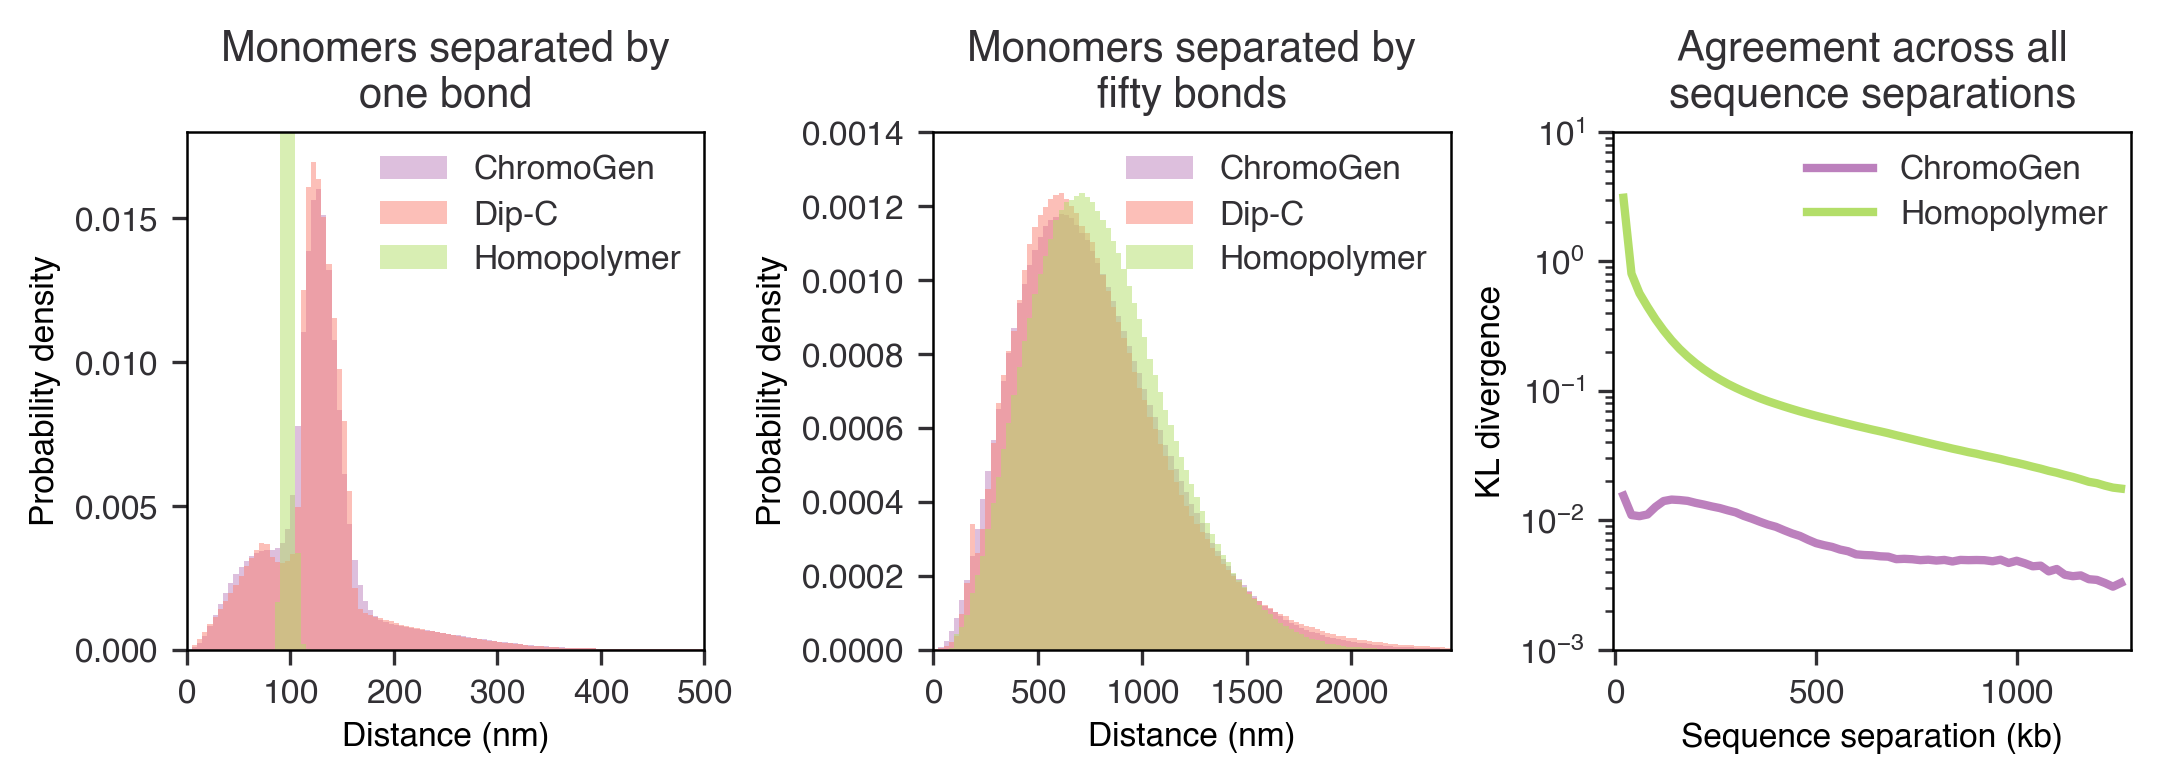

In [15]:
fig,axes = plt.subplots(nrows=1,ncols=3,layout='constrained',figsize=(7.08661,6.69291/2.5))

# Distance histograms
compare_dists(1,bins=torch.arange(0,504,5.),fig=fig,ax=axes[0])
axes[0].set_title('Monomers separated by\none bond')
compare_dists(50,bins=torch.arange(0,2500,25),fig=fig,ax=axes[1])
axes[1].set_title('Monomers separated by\nfifty bonds')

# Distance KL divergence plot
ax = axes[2]
ax.plot(torch.arange(1,64)*20,cgen_KL,label='ChromoGen')
ax.plot(torch.arange(1,64)*20,homo_KL,color='#b3de69',label='Homopolymer')
ax.legend(framealpha=0)
ax.set_yscale('log')
ax.set_xlabel('Sequence separation (kb)')
ax.set_ylabel('KL divergence')
ax.set_xlim([-5,1285])
ylim = ax.get_ylim()
xlim = ax.get_xlim()
ax.set_aspect( 2.5*(xlim[1]-xlim[0])/(ylim[1]-ylim[0]), adjustable='box')
ax.set_title('Agreement across all\nsequence separations')

fig.savefig(pdf_dir / 'distance_stats_with_homopolymer.pdf',transparent=True)

In [16]:
del cgen_KL, homo_KL, homo_dists, dipc_dists, cgen_dists

#### Fig 2c

Note: I made this figure with three panels so that its relative font sizes, etc., would be identical to parts a-b. Later combined everything in Adobe Illustrator. 

In [17]:
def plot_hist(cgen_data,dipc_data,homo_data=None,nbins=25,fig=None,ax=None,alpha=0.5,xlim=None):

    # Convert to numpy to improve speed in plt 
    cgen_data = cgen_data.cpu().numpy()
    dipc_data = dipc_data.cpu().numpy()

    # Create consistent bins for eaach data type
    if xlim is None:
        minn = min(cgen_data.min(),dipc_data.min())
        maxx = max(cgen_data.max(),dipc_data.max())
    else:
        minn = xlim[0]
        maxx = xlim[1]
    delta = (maxx-minn)/nbins
    bins = torch.arange(minn,maxx+delta/2,delta).numpy()

    # Create the figure, if necessary
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    # Create the histogram
    ax.hist(cgen_data,alpha=alpha,bins=bins,label='ChromoGen',edgecolor='none',density=True)
    ax.hist(dipc_data,alpha=alpha,bins=bins,label='Dip-C',edgecolor='none',density=True)
    if homo_data is not None:
        ax.hist(homo_data.cpu().numpy(),alpha=alpha,bins=bins,label='Homopolymer',edgecolor='none',density=True)
    ax.set_ylabel('Probability density')

    # Make a square panel
    if xlim is not None:
        ax.set_xlim(xlim)
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    ax.set_aspect( (xlim[1]-xlim[0])/(ylim[1]-ylim[0]) )

    return fig, ax

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 6 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'R', 'g', 'nonmarkingreturn', 'space']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 53, 74]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 6 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'R', 'g', 'nonmarkingreturn', 'space']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 53, 74]
INFO:fontTools.subset:Closing glyph list over 'glyf': 6 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'R', 'g', 'nonmarkingreturn', 'space']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 53, 74]
I

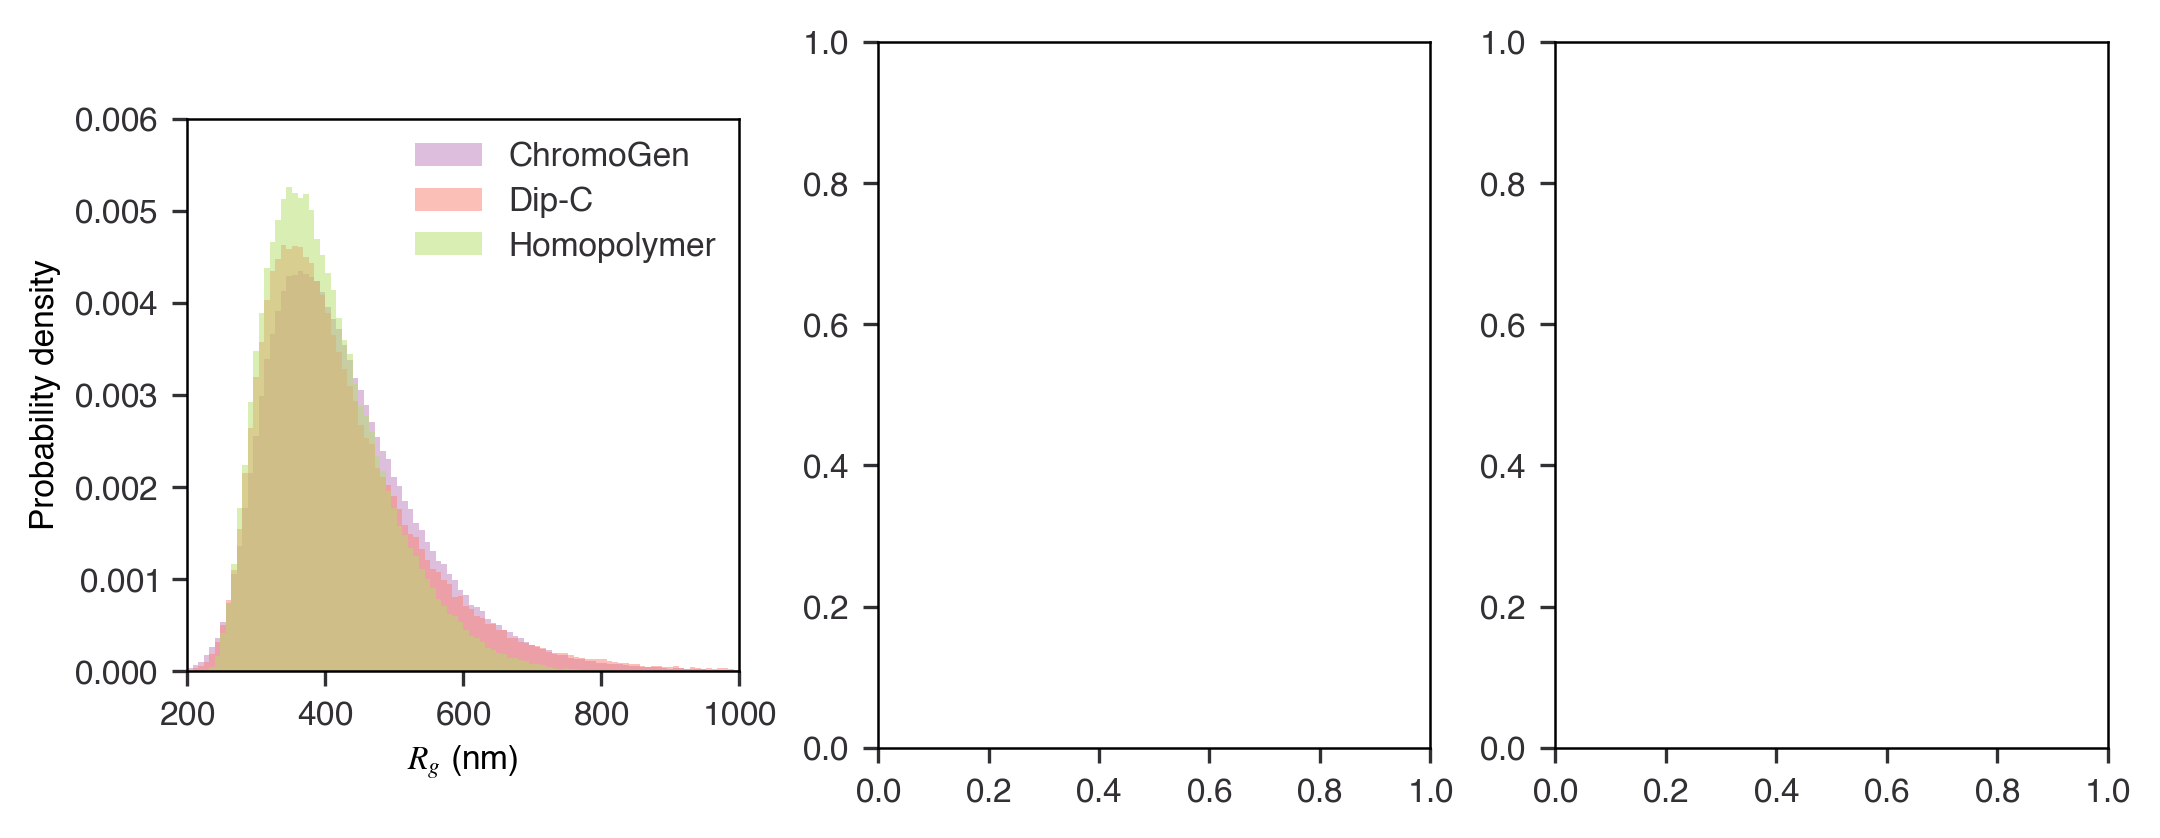

In [18]:
# Load the data and multiply by 100 to convert to nm
homo_rg = torch.load(homo_rg_fp) * 100
dipc_rg = torch.load(dipc_rg_fp) * 100
cgen_rg = torch.load(cgen_rg_fp) * 100 

fig, axes = plt.subplots(ncols=3,nrows=1,layout='constrained',figsize=(7.08661,6.69291/2.5)) # To ensure equal size as the other figure

# R_g histogram
ax = axes[0]
plot_hist(cgen_rg,dipc_rg,homo_rg,fig=fig,ax=ax,nbins=100,xlim=[200,1000])
ax.set_xlabel('$R_g$ (nm)')
ax.legend(framealpha=0,loc='upper right')#,fontsize='small')
fig.savefig(pdf_dir / 'r_g_with_homopolymer.pdf',transparent=True)